# Graded Case 1 (Part I): House price prediction

In this case (Part I), you will build a multilayer perceptron network to predict the selling price of properties. The dataset consists of all single family houses and condos that were sold in Denver in a given year.

You need to submit the following files:

- A pdf or word document containing the plots of the training errors for the multi-layer perception model and the linear regression model, and the answers to the two questions below. You should also provide interpretations and implications of each plot/table in your report. It is not enough to simply put a chart or a table of numbers in the report and expect the audience to understand what the chart means and what it implies. The point is to provide some insights for an audience like senior management at Zillow.

- The complete Juyputer notebook containing all your Pytorch code with explanations, along with a Markdown text explaining different parts if needed.

To get the test error for your model, you need to submit your predicted prices for test data on Kaggle. Note that in Part I of the case, you do not need to worry about optimizing your model to get the lowest error possible. The Part I will be graded based on your implemention of the base model as specified below.  We will come back to optimize the model and the Kaggle competition in Part II of the case.

---
## Data Loading and Visualize Data

The train data and test data are available on Kaggle website.
You can first download them, then upload them to the google colab, and then read the data using pandas.

In [33]:
import pandas as pd  # Importing pandas, which is a library for data manipulation and analysis
#TODO: Read the datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

Let's take a quick look at the data.

In [34]:
# Display the train dataframe
print(train_df.shape)
print(train_df.columns)

(11581, 17)
Index(['ID', 'NBHD', 'PROP_CLASS', 'LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA',
       'LAND_SQFT', 'GRD_AREA', 'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B',
       'HLF_B', 'STORY', 'STYLE_CN', 'UNITS', 'SALE_PRICE'],
      dtype='object')


In [35]:
# Display the test dataframe
print(test_df.shape)
print(test_df.columns)

(4964, 16)
Index(['ID', 'NBHD', 'PROP_CLASS', 'LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA',
       'LAND_SQFT', 'GRD_AREA', 'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B',
       'HLF_B', 'STORY', 'STYLE_CN', 'UNITS'],
      dtype='object')


As you can see, we have 11581 training samples and 4964 test samples, each with 16 features. The training samples contain the sale_prices, which are the labels. The test samples do not contain the sale_prices, which we will predict by building a MLP model.

### Visualization of SALE PRICES in train data

Let's take a closer look at the sale prices in the train data.

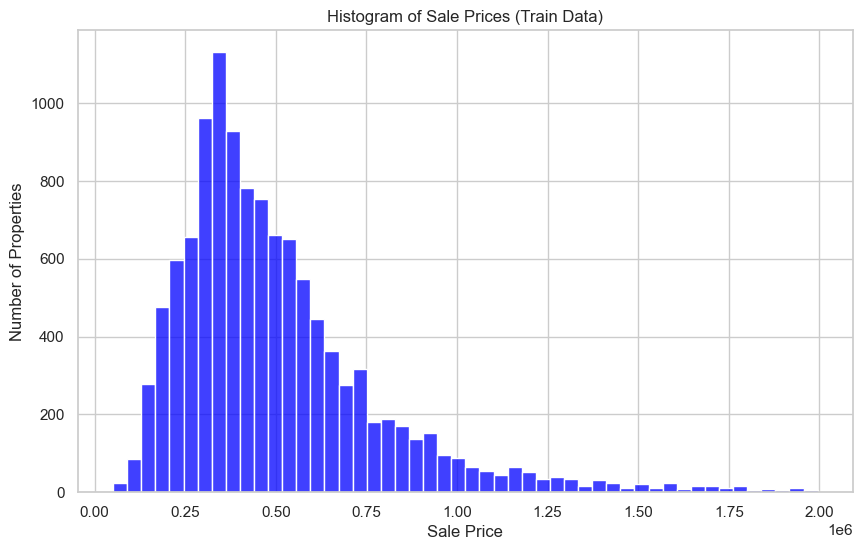

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt  # Importing matplotlib's pyplot, it provides a MATLAB-like interface for making plots and charts

# Set the style
sns.set(style="whitegrid")

# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SALE_PRICE'], bins=50, color='blue')
plt.title('Histogram of Sale Prices (Train Data)')
plt.xlabel('Sale Price')
plt.ylabel('Number of Properties')
plt.show()

In [37]:
print(train_df['SALE_PRICE'].min())
print(train_df['SALE_PRICE'].max())
print(train_df['SALE_PRICE'].median())

51000
1995000
431000.0


We see that the sale_price has a wide range from 50K to 2 million, with the median price 431K.

---
## Data Preparation

The first step when building a neural network model is getting your data into the proper form to feed into the network.

- **Train labels**: We need to extract the sale prices from the train data as train labels. Since the house prices can take very large values, to make training fast it is helpful to define the train labels as the sale prices divided by a normalization factor.

- **Handing non-numeric features**: Some of the house features are non-numeric. We will learn about how to process categorical data in the upcoming lectures. For now, you can  remove those non-numeric features and only train over the numeric features.

- **Feature standardization**: When predicting house prices, you started from features that took a variety of ranges—some features had small floating-point values, and others had fairly large integer values. The model might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice for dealing with such data is to do feature-wise normalization: for each feature in the input data (a column in the input dataframe), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has
a unit standard deviation. Note that here we combine the feature vectors in the train and test data. In this way, the train and test data go through the same normalization.

- **Handling missing values**: There may exist some entries with missing values. After the feature standardization, we can impute the missing values with zeros.

We see that the sale_price in train data has a wide range from 50K to 2 million, with the median price 431K. We can divide the sale_price by 100K, so the normalized sale_price is between 0.5 and 20 in training data. Remember, when we output the predicted price for the test data, we need to multiply back the normalization factor.

In [38]:
#TODO: define labels for train data
normalization_factor=100000
train_labels = train_df['SALE_PRICE']/normalization_factor
train_df.drop('SALE_PRICE', axis=1, inplace=True) # drop the sale_prices in features.

The inplace parameter, when set to True , allows you to drop the rows or columns without returning a new DataFrame. The issue arises when the drop function reorders the DataFrame, which can be problematic when the order of your data matters

In [39]:
train_labels.shape

(11581,)

In [40]:
train_labels

0         2.850
1        12.300
2         4.200
3         3.550
4         3.395
          ...  
11576     3.149
11577     5.395
11578     6.020
11579     3.837
11580     5.500
Name: SALE_PRICE, Length: 11581, dtype: float64

Note that both the training samples and test samples contain an ID column, which is not informative for predicting the house price. Thus we will drop the ID column.

In [41]:
train_ID=train_df['ID']
test_ID=test_df['ID']
train_df.drop('ID', axis=1, inplace=True)
test_df.drop('ID', axis=1, inplace=True)

In [42]:
# Then we combine the feature vectors in the train data and test data
features=pd.concat(objs=[train_df,test_df],axis=0)

In [43]:
numeric_features = features.dtypes[features.dtypes != 'object'].index
non_numeric_features = features.dtypes[features.dtypes == 'object'].index
numeric_features, non_numeric_features

(Index(['LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA', 'LAND_SQFT', 'GRD_AREA',
        'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B', 'HLF_B', 'STORY', 'UNITS'],
       dtype='object'),
 Index(['NBHD', 'PROP_CLASS', 'STYLE_CN'], dtype='object'))

We see that there are three non-numeric features, namely `NBHD`, `PROP_CLASS`, and `STYLE_CN`. We will apply one-hot encoding to those non-numeric features in our model using [`get_dummies`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html); you could also simply drop these non-numeric features.

In [44]:
features= features.drop(non_numeric_features, axis=1)

In [45]:
# Standardize numeric features
features[numeric_features] = features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

In [46]:
# recheck the mean and std after standardization
features[numeric_features].mean(), features[numeric_features].std()

(LIVING_SQFT   -6.919686e-17
 FBSMT_SQFT    -7.907445e-17
 BSMT_AREA      5.829929e-17
 LAND_SQFT      1.792998e-17
 GRD_AREA      -1.975519e-17
 BLDG_AGE      -1.385011e-17
 RM_AGE         2.795645e-17
 BED_RMS        2.122341e-16
 FULL_B         1.469829e-16
 HLF_B         -5.658145e-17
 STORY         -4.563020e-18
 UNITS          5.017175e-16
 dtype: float64,
 LIVING_SQFT    1.0
 FBSMT_SQFT     1.0
 BSMT_AREA      1.0
 LAND_SQFT      1.0
 GRD_AREA       1.0
 BLDG_AGE       1.0
 RM_AGE         1.0
 BED_RMS        1.0
 FULL_B         1.0
 HLF_B          1.0
 STORY          1.0
 UNITS          1.0
 dtype: float64)

We see that after standardization, the features for the train data have mean 0 and standard deviation 1.

In [47]:
# After the feature standardization, we can impute the missing values with zeros.
features[numeric_features] = features[numeric_features].fillna(0)

Double check the features after data processing.

In [48]:
features.info()
print(features.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16545 entries, 0 to 4963
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LIVING_SQFT  16545 non-null  float64
 1   FBSMT_SQFT   16545 non-null  float64
 2   BSMT_AREA    16545 non-null  float64
 3   LAND_SQFT    16545 non-null  float64
 4   GRD_AREA     16545 non-null  float64
 5   BLDG_AGE     16545 non-null  float64
 6   RM_AGE       16545 non-null  float64
 7   BED_RMS      16545 non-null  float64
 8   FULL_B       16545 non-null  float64
 9   HLF_B        16545 non-null  float64
 10  STORY        16545 non-null  float64
 11  UNITS        16545 non-null  float64
dtypes: float64(12)
memory usage: 1.6 MB
Index(['LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA', 'LAND_SQFT', 'GRD_AREA',
       'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B', 'HLF_B', 'STORY', 'UNITS'],
      dtype='object')


Now, we are left with 12 features.

In [49]:
# check whether there is any missing entry
print(features.isnull().sum())

LIVING_SQFT    0
FBSMT_SQFT     0
BSMT_AREA      0
LAND_SQFT      0
GRD_AREA       0
BLDG_AGE       0
RM_AGE         0
BED_RMS        0
FULL_B         0
HLF_B          0
STORY          0
UNITS          0
dtype: int64


In [50]:
#TODO: Write code to construct feature vectors for train and test data after data preparation.
train_features = features.iloc[:len(train_labels)]
test_features = features.iloc[len(train_labels):]

In [51]:
train_features.shape, test_features.shape

((11581, 12), (4964, 12))

Finally, we convert features and labels to PyTorch tensors.

In [52]:
import torch
import numpy as np

# Convert training features and labels to PyTorch tensors
train_features = torch.tensor(train_features.values.astype(np.float32), dtype=torch.float32)
test_features = torch.tensor(test_features.values.astype(np.float32), dtype=torch.float32)
train_labels = torch.tensor(train_labels.values.reshape(-1, 1).astype(np.float32), dtype=torch.float32)

---
## DataLoaders and Batching

After creating training, test, and validation data, we can create DataLoaders for this data by following two steps:
1. Create a known format for accessing our data, using [TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) which takes in an input set of data and a target set of data with the same first dimension, and creates a dataset.
2. Create DataLoaders and batch our training, validation, and test Tensor datasets. Note that we will shuffle the train data, so the model will not learn a particular order. For test data, we do not shuffle.

In [53]:
from torch.utils.data import TensorDataset, DataLoader
#  Create DataLoaders and batch our train data
train_data = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

In [54]:
#TODO: Create DataLoaders and batch our test data
test_data =TensorDataset(test_features)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

Let's take a batch to have a sanity check

In [55]:
# obtain one batch of training data
dataiter = iter(train_loader)
features, labels = next(dataiter)

print('Sample input size: ', features.size()) # batch_size, seq_length
print('Sample input: \n', features)
print()
print('Sample label size: ', labels.size()) # batch_size
print('Sample label: \n', labels)

Sample input size:  torch.Size([128, 12])
Sample input: 
 tensor([[ 0.8049, -0.6920,  0.8300,  ...,  1.0768,  0.7971, -0.1079],
        [ 1.6835, -0.6920,  1.1136,  ...,  1.0768,  2.3446, -0.1079],
        [ 1.0846, -0.6920,  0.0079,  ...,  1.0768,  2.3446, -0.1079],
        ...,
        [-0.7781, -0.6920, -0.8231,  ..., -0.7753, -0.7504, -0.1079],
        [ 0.7247,  1.0287,  0.9564,  ...,  1.0768,  0.7971, -0.1079],
        [-1.1014, -0.6920,  0.3891,  ..., -0.7753, -0.7504, -0.1079]])

Sample label size:  torch.Size([128, 1])
Sample label: 
 tensor([[ 4.1710],
        [ 3.7800],
        [ 6.2000],
        [ 2.8200],
        [ 6.6685],
        [ 2.9300],
        [ 6.0500],
        [ 4.0500],
        [ 5.1500],
        [ 5.7267],
        [ 6.4500],
        [ 3.0500],
        [ 4.7119],
        [ 2.3000],
        [ 6.5000],
        [ 2.0500],
        [ 1.2250],
        [ 2.9900],
        [ 1.8531],
        [ 3.0500],
        [ 4.2000],
        [15.2000],
        [ 2.9500],
        [ 1.3

---
## Linear Regression as Benchmark

Let us build a linear regression model as a benchmark. Note that the linear regression model can be viewed as a special instance of multi-layer perception with no hidden layer and a single output neuron.

In [56]:
#TODO: Build a linear regression model network
import torch.nn as nn
lin_net = nn.Linear(train_features.shape[1], 1)

Let's print out the model achitecture.

In [57]:
lin_net

Linear(in_features=12, out_features=1, bias=True)

Let's take a batch and see the output


In [58]:
features, labels = next(dataiter)
output=lin_net(features)
output.shape,labels.shape

(torch.Size([128, 1]), torch.Size([128, 1]))

## Train the model

First, we will use GPU training if it is availabe.

In [59]:
#TODO: use GPU for training if it is availabe
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lin_net = lin_net.to(device)

Second, let us specify the loss function.

In [60]:
#TODO: specify the loss function for training
criterion = nn.MSELoss()

We are now ready to train the network.

Note that with house prices, as with stock prices, we care about relative quantities more than absolute quantities. Thus we tend to care more about the relative error than about the absolute error. For instance, if our prediction is off by \\$100,000 when estimating the sale price of a house which is \\$125,000, then we are probably doing a horrible job. On the other hand, if we err by this amount for a house with sale price \\$2 million, this might represent a pretty  accurate prediction.

To this end, we will use the median error rate (MER) used by [Zestimate](https://www.zillow.com/z/zestimate/) to measure the predictive performance. The error rate is defined as
$$
\text{Error Rate} = \left| \frac{\text{Predicted Price}-\text{Actual Price}}{\text{Actual Price}} \right|
$$
The median error rate is defined as the median of error rates for all properties.

In [61]:
#TODO: Write code to train the network
def train(model, train_loader, num_epochs, learning_rate=0.001):
    train_losses = []                                       # To store training losses
    train_errors = []                                       # To store training error rates
    # Initialize the optimizer, we use Adam here
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # 0. Loop over the train datasets multiple times
    for epoch in range(num_epochs):
        tot_train_loss = 0.0                            # Store the total training MSE loss for this epoch
        train_error_rates =torch.tensor([]).to(device)  # Store the training error rates for this epoch
        for features, labels in train_loader:           # For each batch in DataLoader
            # Move data to device (GPU or CPU)
            features = features.to(device)
            labels = labels.to(device)

            #1. Compute the output
            output = model(features)
            #2. Compute loss
            loss = criterion(output, labels)
            #3. Clear the gradients from previous iteration
            optimizer.zero_grad()
            #4. Backpropagate the error to compute gradients
            loss.backward()
            #5. Update the weights
            optimizer.step()

            tot_train_loss += loss.item()

            # Compute and store error rate for training data
            train_error_rate = torch.absolute(output/labels-1)
            train_error_rates= torch.cat((train_error_rates,train_error_rate),dim=0)


        train_loss = tot_train_loss /len(train_loader)
        train_error = torch.median(train_error_rates).item()
        train_losses.append(train_loss)
        train_errors.append(train_error)
        # Print the training loss and validation loss every 10 epochs
        if epoch % 10 == 0:
            print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
              "Train Loss: {:.3f}.. ".format(train_loss),
              "Train Median Error Rate: {:.3f}.. ".format(train_error),
              )

    return  train_losses,train_errors

In [62]:
train_losses, train_errors = train(lin_net, train_loader, num_epochs=500, learning_rate=0.001)

Epoch: 1/500..  Train Loss: 36.410..  Train Median Error Rate: 1.011.. 
Epoch: 11/500..  Train Loss: 22.918..  Train Median Error Rate: 0.871.. 
Epoch: 21/500..  Train Loss: 16.264..  Train Median Error Rate: 0.719.. 
Epoch: 31/500..  Train Loss: 11.430..  Train Median Error Rate: 0.570.. 
Epoch: 41/500..  Train Loss: 8.037..  Train Median Error Rate: 0.428.. 
Epoch: 51/500..  Train Loss: 5.847..  Train Median Error Rate: 0.315.. 
Epoch: 61/500..  Train Loss: 4.603..  Train Median Error Rate: 0.255.. 
Epoch: 71/500..  Train Loss: 4.015..  Train Median Error Rate: 0.234.. 
Epoch: 81/500..  Train Loss: 3.841..  Train Median Error Rate: 0.223.. 
Epoch: 91/500..  Train Loss: 3.834..  Train Median Error Rate: 0.220.. 
Epoch: 101/500..  Train Loss: 3.818..  Train Median Error Rate: 0.219.. 
Epoch: 111/500..  Train Loss: 3.813..  Train Median Error Rate: 0.220.. 
Epoch: 121/500..  Train Loss: 3.813..  Train Median Error Rate: 0.219.. 
Epoch: 131/500..  Train Loss: 3.818..  Train Median Error 

Plot the training error (MER) over epochs

In [77]:
#TODO: Write code to plot the training error (MER) over epochs
import matplotlib.pyplot as plt
def plot_errors(train_errors, num_epochs):
    plt.figure(figsize=(10, 7))
    plt.plot(range(1, num_epochs + 1), train_errors, label='train')
    plt.xlabel('epoch')
    plt.ylabel('median error rate')
    plt.legend()
    plt.show()

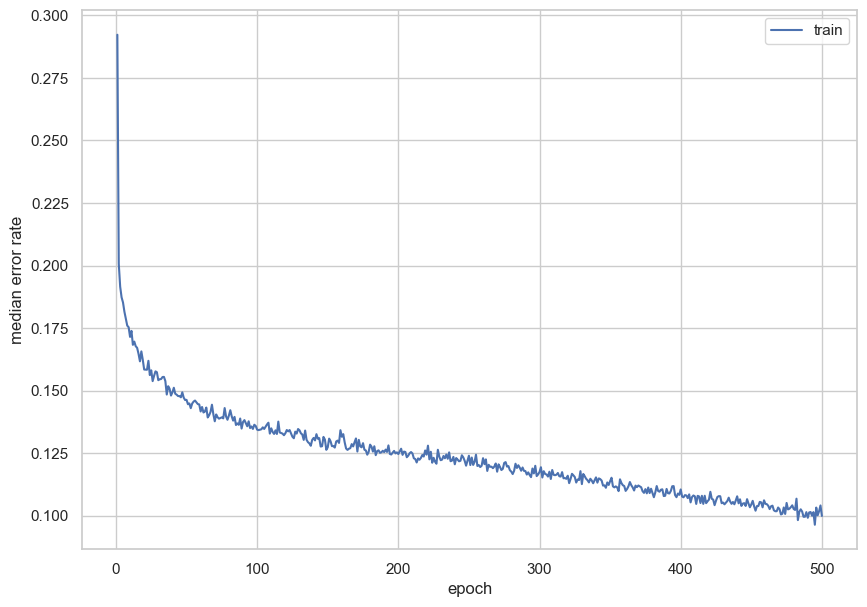

In [78]:
plot_errors(train_errors, num_epochs=500)

---
## Build the Multi-layer Perceptron Base Model

In the following, we build a multi-layer perception model.

In [65]:
#TODO: Build a multi-layer perception neural network with 2 hidden layers of sizes 256 and 128, respectively and ReLu activations
import torch.nn as nn
model = nn.Sequential(nn.Linear(train_features.shape[1], 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128,1))

In [66]:
model=model.to(device)

In [67]:
#TODO: write code to train the MLP network
train_losses, train_errors = train(model, train_loader, num_epochs=500, learning_rate=0.001)

Epoch: 1/500..  Train Loss: 7.875..  Train Median Error Rate: 0.292.. 
Epoch: 11/500..  Train Loss: 2.613..  Train Median Error Rate: 0.174.. 
Epoch: 21/500..  Train Loss: 2.368..  Train Median Error Rate: 0.158.. 
Epoch: 31/500..  Train Loss: 2.284..  Train Median Error Rate: 0.155.. 
Epoch: 41/500..  Train Loss: 2.134..  Train Median Error Rate: 0.151.. 
Epoch: 51/500..  Train Loss: 2.049..  Train Median Error Rate: 0.145.. 
Epoch: 61/500..  Train Loss: 1.972..  Train Median Error Rate: 0.143.. 
Epoch: 71/500..  Train Loss: 1.877..  Train Median Error Rate: 0.140.. 
Epoch: 81/500..  Train Loss: 1.872..  Train Median Error Rate: 0.142.. 
Epoch: 91/500..  Train Loss: 1.845..  Train Median Error Rate: 0.138.. 
Epoch: 101/500..  Train Loss: 1.693..  Train Median Error Rate: 0.134.. 
Epoch: 111/500..  Train Loss: 1.638..  Train Median Error Rate: 0.133.. 
Epoch: 121/500..  Train Loss: 1.625..  Train Median Error Rate: 0.134.. 
Epoch: 131/500..  Train Loss: 1.598..  Train Median Error Rate

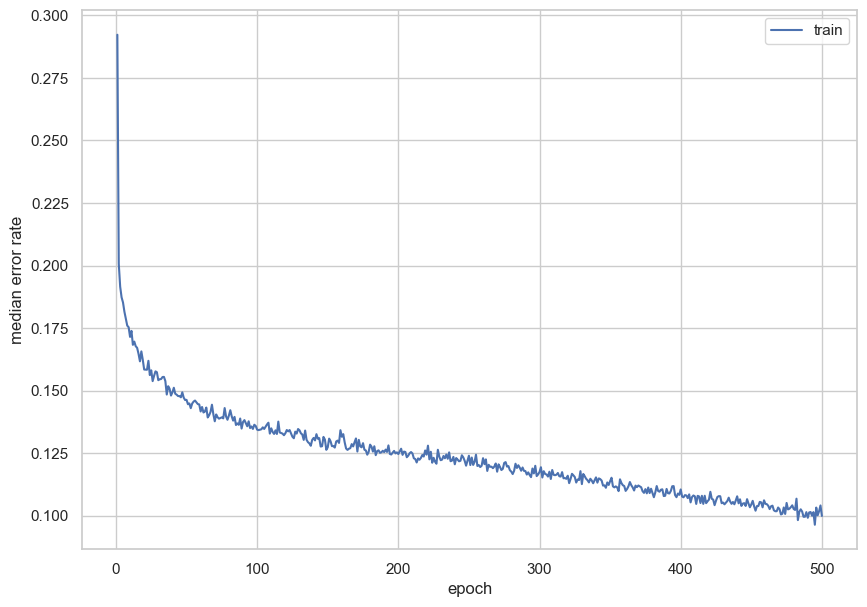

In [68]:
#TODO: Write code to plot the training error (MER) over epochs
plot_errors(train_errors, num_epochs=500)

**Question 1**: What are your final training errors of the multilayer perception model and the linear regression model?

We can see that the training error of the linear regression model is around 22% and training error of the multilayer perception model is around 10%.

---
## Inference on test data

After the MLP model is trained, we can use it for inference.

 We need to remember to set the model in inference mode with model.eval(). You'll also want to turn off autograd with the torch.no_grad() context.

In [69]:
#TODO: write the code to generate predicted sale prices for test data
# Test our network for one batch
model.eval()
dataiter = iter(test_loader)
features,= next(dataiter)
features=features.to(device)
output = model(features)

In [70]:
def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    # In evaluation (or testing) mode, we don't want any parameter updates. We want the model to give
    # the final output based on current parameter values.
    pred_labels = torch.tensor([]).to(device)
    with torch.no_grad():
      for features, in test_loader:
            # Move data to device (GPU or CPU)
            features = features.to(device)
            output = model(features)  # Compute the output
            # store prediction results
            pred_labels = torch.cat((pred_labels,output),dim=0)
    return  pred_labels

In [71]:
pred_labels =test(model,test_loader)

Remember when predict the price, we need to multiply back the normalization factor

In [72]:
pred_labels=pred_labels*normalization_factor

In [73]:
pred_labels[:20]

tensor([[ 558809.5000],
        [ 514596.2188],
        [ 453953.8438],
        [ 280958.3750],
        [ 681949.0000],
        [ 379961.1875],
        [ 512755.5000],
        [ 826508.8750],
        [ 382358.8750],
        [ 361864.0312],
        [ 274354.9688],
        [ 562594.7500],
        [ 613167.0000],
        [ 309185.9688],
        [1295543.5000],
        [ 233225.6094],
        [ 427275.0000],
        [ 245046.8594],
        [ 210606.3594],
        [1272921.7500]])

In [74]:
data = {'ID': test_ID, 'SALE_PRICE': pred_labels.cpu().numpy().squeeze()}
pred_df=pd.DataFrame(data)
pred_df.head()

,ID,SALE_PRICE
0,144650,558809.50000
1,495961,514596.21875
2,582423,453953.84375
3,966643,280958.37500
4,795229,681949.00000


In [79]:
pred_df

,ID,SALE_PRICE
0,144650,558809.50000
1,495961,514596.21875
2,582423,453953.84375
3,966643,280958.37500
4,795229,681949.00000
...,...,...
4959,525377,579318.62500
4960,322001,450776.28125
4961,124447,388113.62500
4962,25138,589343.31250


Save the dataframe to CSV file without index by setting index=False.

In [75]:
#TODO: save the predicted sale prices into submission_csv
pred_df.to_csv('submission.csv', index=False)

Now, we can submit our predictions on Kaggle and see how they compare with the actual house prices (labels) on the test set.

- Log in to the Kaggle website and visit the house price prediction competition page.

- Click the “Submit Predictions” button.

- Click the “Upload Submission File” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.

- Click the “Make Submission” button at the bottom of the page to view your results.

**Question 2**: What is the test error shown on Kaggle? How does it compare with the train error?

It turns out that the test error is around 15%, which is much higher than the train error.

---
## Evaluate test error

**Note**: To evaluate test error, you need to have access to the true sale prices for test error. No need to run the following code!!! Instead, you will get the test error by submitting your predictions on Kaggle as described above!

In [76]:
df_sol=pd.read_csv('solution.csv')
df_sol.head()


FileNotFoundError: [Errno 2] No such file or directory: 'solution.csv'

In [ ]:
test_labels=df_sol['SALE_PRICE'].values

In [ ]:
test_labels.shape

In [ ]:
# Compute and store median error rate for validation data
test_errors=pred_labels.cpu().numpy().squeeze()/test_labels-1
test_errors.shape

In [ ]:
median_test_error=np.median(np.absolute(test_errors)).item()

In [ ]:
median_test_error

## Conclusion

We see that the median test error is around 15%. In Part II of Case 1, you will be asked to vary model architecture or optimization algorithms to see if you can squeeze out a lower test error.